### FairFace Dataset as pseudo-labeling, evaluated on All-Age-Face Data (AAF - Mostly Asian)

In [1]:
# https://www.kaggle.com/datasets/aibloy/fairface

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from pathlib import Path
from timm import create_model
!pip install torchmetrics
from torchmetrics.classification import BinaryAccuracy, Accuracy

tqdm.pandas()

base_img = Path('FairFace')

train_df = pd.read_csv('FairFace/train_labels.csv')
val_df = pd.read_csv('FairFace/val_labels.csv')

train_df.drop(columns=['race','service_test'],inplace=True)
val_df.drop(columns=['race','service_test'],inplace=True)

train_df['file'] = train_df['file'].progress_map(lambda x:base_img/x)
val_df['file'] = val_df['file'].progress_map(lambda x:base_img/x)

train_df['age'] = train_df['age'].astype('category')
train_df['age_code'] = train_df['age'].cat.codes

age_map = dict(zip(train_df['age'].cat.categories,range(len(train_df['age'].cat.categories))))
gender_map = {'Male': 0, 'Female': 1}

train_df['gender_code'] = train_df['gender'].progress_map(lambda x:gender_map[x])

val_df['age_code'] = val_df['age'].progress_map(lambda x:age_map[x])
val_df['gender_code'] = val_df['gender'].progress_map(lambda x:gender_map[x])



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [4]:

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### FairFace Data Retrieval


In [16]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fairface:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F912830%2F1547126%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240522%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240522T072435Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D777a812f8956ff8e4af8c443bd09e4de091469842af7d48db5c23b5041a1b8e7cc8232287992e0155dfe296755dc980069b01590bec5f481b5f917676ba04c19ae2e83aafb39c0ac14b0b8eba35d3263f822260fc45ab5495601885799076609074190d36665aed5118de0275aa3fdf4198034e1bea9cb28d78fa8d177daaba14fa768632dc895d3e9485f6ab99520509b48e26319d33830415b94df1a62524d171162799b15cff4b7fdf063d4fdcbbeb577368ed4151b48a84cfe268f5a55f960f9a8113882ac0c5368a517f4c6b88e66a37b48b35c979151c872ae9bd0c3a69426651851d0ddeee8defa76b1570446e79bd6e3b0f1a3d2395bf5a26a592044'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

The system cannot find the path specified.


OSError: [WinError 1314] A required privilege is not held by the client: '/kaggle/input' -> '..\\input'

### Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from pathlib import Path
from timm import create_model
from torchmetrics.classification import BinaryAccuracy, Accuracy

tqdm.pandas()

In [6]:
base_img = Path('FairFace')
train_df = pd.read_csv('FairFace/train_labels.csv')
val_df = pd.read_csv('FairFace/val_labels.csv')

train_df.drop(columns=['race','service_test'],inplace=True)
val_df.drop(columns=['race','service_test'],inplace=True)

train_df['file'] = train_df['file'].progress_map(lambda x:base_img/x)
val_df['file'] = val_df['file'].progress_map(lambda x:base_img/x)

train_df['age'] = train_df['age'].astype('category')
train_df['age_code'] = train_df['age'].cat.codes

age_map = dict(zip(train_df['age'].cat.categories,range(len(train_df['age'].cat.categories))))
gender_map = {'Male': 0, 'Female': 1}

train_df['gender_code'] = train_df['gender'].progress_map(lambda x:gender_map[x])

val_df['age_code'] = val_df['age'].progress_map(lambda x:age_map[x])
val_df['gender_code'] = val_df['gender'].progress_map(lambda x:gender_map[x])

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [33]:
import shutil

# Define directories for FairFace dataset
dataset_path_orig = Path("FairFace")
dataset_path_dest = Path("./fairface_gender_classification_dataset")
os.makedirs(dataset_path_dest, exist_ok=True)

dataset_path_training = dataset_path_dest / "Training"
dataset_path_validation = dataset_path_dest / "Validation"
os.makedirs(dataset_path_training, exist_ok=True)
os.makedirs(dataset_path_validation, exist_ok=True)

dataset_path_training_female = dataset_path_training / "female"
dataset_path_training_male = dataset_path_training / "male"
dataset_path_validation_female = dataset_path_validation / "female"
dataset_path_validation_male = dataset_path_validation / "male"
os.makedirs(dataset_path_training_female, exist_ok=True)
os.makedirs(dataset_path_training_male, exist_ok=True)
os.makedirs(dataset_path_validation_female, exist_ok=True)
os.makedirs(dataset_path_validation_male, exist_ok=True)


Validation dataset size: 5691
Class names: ['female', 'male']


In [8]:
# Filter FairFace dataset by gender and age
for index, row in train_df.iterrows():
    img_path_orig = row['file']
    gender = row['gender_code']

    if gender == 1:  # Female
        img_path_dest = dataset_path_training_female / img_path_orig.name
    elif gender == 0:  # Male
        img_path_dest = dataset_path_training_male / img_path_orig.name
    else:
        print('Weird things happening')

    shutil.copy(str(img_path_orig), str(img_path_dest))

for index, row in val_df.iterrows():
    img_path_orig = row['file']
    gender = row['gender_code']

    if gender == 1:  # Female
        img_path_dest = dataset_path_validation_female / img_path_orig.name
    elif gender == 0:  # Male
        img_path_dest = dataset_path_validation_male / img_path_orig.name
    else:
        print('Weird things happening')

    shutil.copy(str(img_path_orig), str(img_path_dest))

In [9]:
age_map, gender_map

({'0-2': 0,
  '10-19': 1,
  '20-29': 2,
  '3-9': 3,
  '30-39': 4,
  '40-49': 5,
  '50-59': 6,
  '60-69': 7,
  'more than 70': 8},
 {'Male': 0, 'Female': 1})

In [10]:
val_df.head()

,file,age,gender,age_code,gender_code
0,FairFace\val\1.jpg,3-9,Male,3,0
1,FairFace\val\2.jpg,50-59,Female,6,1
2,FairFace\val\3.jpg,30-39,Male,4,0
3,FairFace\val\4.jpg,20-29,Female,2,1
4,FairFace\val\5.jpg,20-29,Male,2,0


In [7]:
data_dir =  "./fairface_gender_classification_dataset"

# Define the folders in the training and validation directories
train_folders = ['male', 'female']
val_folders = ['male', 'female']

# Function to count the number of pictures in each folder
def count_pictures(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len(files)
    return count

# Print the number of pictures in each training folder
print("Number of pictures in each training folder:")
for folder in train_folders:
    folder_path = os.path.join(data_dir, 'Training', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

# Print the number of pictures in each validation folder
print("\nNumber of pictures in each validation folder:")
for folder in val_folders:
    folder_path = os.path.join(data_dir, 'Validation', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

Number of pictures in each training folder:
male: 45986
female: 40758

Number of pictures in each validation folder:
male: 5792
female: 5162


In [1]:

import os
import shutil
import pandas as pd
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)
print(torch.version.cuda)

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("CUDA not detected.")

random.seed(123)

# change to cpu
# device = torch.device("cpu")


cuda:0
12.1
CUDA Available: True
Device Name: NVIDIA GeForce GTX 1650 Ti
CUDA Version: 12.1


In [2]:
import requests

# Define the URL for the file
url = "https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1"

# Define the path where the file will be saved
output_path = "classification_model.pth"

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open(output_path, "wb") as file:
        file.write(response.content)  # Write the content of the response to the file
    print(f"File downloaded successfully and saved as {output_path}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")
    # Load pre-trained weights from .pth file
# Load pre-trained ResNet model CNN-based Face-Gender-Classification PyTorch model 
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer for binary classification

pretrained_weights_path = 'classification_model.pth'
model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))

File downloaded successfully and saved as classification_model.pth


In [12]:

# Load pre-trained weights from .pth file
pretrained_weights_path = 'classification_model.pth'
model.load_state_dict(torch.load(pretrained_weights_path, map_location=torch.device('cpu')))

# Send model to device
model.to(device)


C:\Users\haohu\AppData\Local\Temp\ipykernel_24768\2580958553.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_weights_path, ma

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
### Dataset to be Evaluated
import os
import shutil
import pandas as pd
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)
random.seed(123)

# Dataset 3
dataset_path_sets = Path("./gender_classification_dataset_asia_raw/All-Age-Faces Dataset/image sets")
dataset_path_orig = Path("./gender_classification_dataset_asia_raw/All-Age-Faces Dataset/original images")
dataset_path_dest = Path("./gender_classification_dataset_asia")
os.makedirs(dataset_path_dest, exist_ok=True)

dataset_path_training = dataset_path_dest / "Training"
dataset_path_validation = dataset_path_dest / "Validation"
os.makedirs(dataset_path_training, exist_ok=True)
os.makedirs(dataset_path_validation, exist_ok=True)

dataset_path_training_female = dataset_path_training / "female"
dataset_path_training_male = dataset_path_training / "male"
dataset_path_validation_female = dataset_path_validation / "female"
dataset_path_validation_male = dataset_path_validation / "male"
os.makedirs(dataset_path_training_female, exist_ok=True)
os.makedirs(dataset_path_training_male, exist_ok=True)
os.makedirs(dataset_path_validation_female, exist_ok=True)
os.makedirs(dataset_path_validation_male, exist_ok=True)

# Dataset 3
# https://pythonawesome.com/all-age-faces-dataset-mostly-asian/
# From original dataset webpage:
# Individuals from serial number 00000 to 07380 are all female, from 07381 to 13321 are male.
# Typical code: 00013A02.jpg --> image 00013, Age 02 years old
cols = ['img', 'label']
df_train = pd.read_csv(dataset_path_sets / "train.txt", sep=' ', header=None, names=cols)
df_val = pd.read_csv(dataset_path_sets / "val.txt", sep=' ', header=None, names=cols)

for idx, row in df_train.iterrows():
  img_name = row['img']
  label = row['label']
  img_path_orig = dataset_path_orig / img_name
  img_num = img_name[:5]
  img_age = img_name[6:8]
  if int(img_age) >= 18: # Only consider adults
    if label == 0:
      img_path_dest = dataset_path_training_female / img_path_orig.name
    elif label == 1:
      img_path_dest = dataset_path_training_male / img_path_orig.name
    else:
      print('Weird things happening')

    shutil.copy(str(img_path_orig), str(img_path_dest))

for idx, row in df_val.iterrows():
  img_name = row['img']
  label = row['label']
  img_path_orig = dataset_path_orig / img_name
  img_num = img_name[:5]
  img_age = img_name[6:8]
  if int(img_age) >= 18:
    if label == 0:
      img_path_dest = dataset_path_validation_female / img_path_orig.name
    elif label == 1:
      img_path_dest = dataset_path_validation_male / img_path_orig.name
    else:
      print('Weird things happening')

    shutil.copy(str(img_path_orig), str(img_path_dest))
    

cuda:0


In [8]:
#CREATE UNLABELED DATALOADER FROM THE TRAINING SPLIT
#From training dataset, take the data out of "female" and "male" folders
import os
from shutil import copy

data_dir = "./gender_classification_dataset_asia" # this is the evaluation dataset

fairface_data_dir = "./fairface_gender_classification_dataset/Training"

# pseudo-labeling path
# Define paths for the male and female subfolders
#male_folder = os.path.join(data_dir, "Training", "male")
# male_folder = "/kaggle/input/male-unchecked-nhk"
# use FairFace for pseudo-labeling
male_folder = "fairface_gender_classification_dataset/Training/male"
#female_folder = os.path.join(data_dir, "Training", "female")
# female_folder = "/kaggle/input/female-unchecked-nhk"
female_folder = "fairface_gender_classification_dataset/Training/female"

unlabeled_folder = os.path.join(fairface_data_dir, "Unlabeled")
os.makedirs(unlabeled_folder, exist_ok=True)

# Copy all files from male and female subfolders to the unlabeled folder
for folder in [male_folder, female_folder]:
    for filename in os.listdir(folder):
        source_path = os.path.join(folder, filename)
        destination_path = os.path.join(unlabeled_folder, filename)
        copy(source_path, destination_path)

print(f"Unlabeled dataset prepared in: {unlabeled_folder}")
print(f"Number of images in the unlabeled dataset: {len(os.listdir(unlabeled_folder))}")

# The Asia dataset remains intact for evaluation
evaluation_data_dir = data_dir
unlabeled_folder = os.path.join(fairface_data_dir, "Unlabeled")
print(f"Evaluation dataset available at: {evaluation_data_dir}")

# Define the folders in the training and validation directories
train_folders = ['male', 'female']
val_folders = ['male', 'female']

# Function to count the number of pictures in each folder
def count_pictures(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len(files)
    return count

# Print the number of pictures in each training folder
print("Number of pictures in each training folder:")
for folder in train_folders:
    folder_path = os.path.join(evaluation_data_dir, 'Training', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

# Print the number of pictures in each validation folder
print("\nNumber of pictures in each validation folder:")
for folder in val_folders:
    folder_path = os.path.join(evaluation_data_dir, 'Validation', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

Unlabeled dataset prepared in: ./fairface_gender_classification_dataset/Training\Unlabeled
Number of images in the unlabeled dataset: 86744
Evaluation dataset available at: ./gender_classification_dataset_asia
Number of pictures in each training folder:
male: 2510
female: 3144

Number of pictures in each validation folder:
male: 1262
female: 1584


In [2]:
# Define the transformations
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# clean cache
torch.cuda.empty_cache()
# check if the cache is empty
print(torch.cuda.memory_summary(device=None, abbreviated=False))
# check if cuda is available
print(torch.cuda.is_available())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [ ]:
#create the new dataset from unlabaled data that now is labeled
from PIL import Image
from torch.utils.data import DataLoader
import os
import shutil
import torch
import torch.nn as nn
import torchvision
import psutil

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print(torch.cuda.is_available())
torch.cuda.empty_cache()

# switch to cpu
device = torch.device("cpu")
model.to(device)

# check which device the model is on
print(next(model.parameters()).device)



# Define a function to display images
def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

# Define a threshold for pseudo-labeling confidence
pseudo_label_threshold = 0.9

# Define paths for the output AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia"
aaf_training_pseudo_path = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the pseudo-labeled samples from FairFace
aaf_training_female_path = os.path.join(aaf_training_pseudo_path, "female")
aaf_training_male_path = os.path.join(aaf_training_pseudo_path, "male")

# Create directories if they don't exist
os.makedirs(aaf_dataset_path, exist_ok=True)
os.makedirs(aaf_training_pseudo_path, exist_ok=True)
os.makedirs(aaf_training_female_path, exist_ok=True)
os.makedirs(aaf_training_male_path, exist_ok=True)

# Set model to evaluation mode
model.eval()
data_dir = "./gender_classification_dataset_asia" # this is the dataset we want to evaluate on (AAF)
evaluation_data_dir = data_dir
fairface_data_dir = "./fairface_gender_classification_dataset/Training" # this is the training dataset (FairFace)
unlabeled_folder = os.path.join(fairface_data_dir, "Unlabeled") # pseudo-labeling path

# List to store pseudo-labeled samples
pseudo_labeled_samples = []
processed_images = 0
# Iterate over the unlabeled dataset
for filename in os.listdir(unlabeled_folder):
    # Load the image
    img_path = os.path.join(unlabeled_folder, filename)
    img = Image.open(img_path).convert('RGB')  # Make sure it's RGB
    img = transforms_val(img)  # Apply transformations

    # Forward pass through the model
    with torch.no_grad(): # No need to track the gradients
        inputs = img.unsqueeze(0).to(device)  # Unsqueeze to add batch dimension
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

    # Select samples with high confidence
    confident_mask = max_probs > pseudo_label_threshold
    if confident_mask.any():
        # Append confident samples with their pseudo labelss
        pseudo_labeled_samples.extend([(img, pred) for img, pred in zip(inputs[confident_mask], preds[confident_mask])]) # I don't think this is necessary 
        # Determine destination folder based on label
        for pred_label in preds[confident_mask]:
            #print(pred_label)
            if pred_label == 1:
                destination_folder = aaf_training_male_path
                #print('Its male')
            elif pred_label == 0:
                destination_folder = aaf_training_female_path
                #print('Its female')
            else:
                continue  # Skip samples with unexpected labels
            # Copy the image to the destination folder
            shutil.copy(img_path, destination_folder)
    
    processed_images += 1
    if processed_images % 100 == 0:
        print(f"Processed {processed_images} images")
        print(f"RAM usage: {psutil.virtual_memory().used / 1e9:.2f} GB")
    # make sure to free up memory
    del img, inputs, outputs, probs, max_probs, preds, confident_mask
    torch.cuda.empty_cache()


# Convert the pseudo-labeled samples to a dataset
class PseudoLabeledDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Create a dataset using the pseudo-labeled samples
# pseudo_labeled_dataset = PseudoLabeledDataset(pseudo_labeled_samples, transforms_val)
pseudo_labeled_dataset = PseudoLabeledDataset(pseudo_labeled_samples)

# Create a dataloader for the pseudo-labeled dataset
pseudo_labeled_dataloader = DataLoader(pseudo_labeled_dataset, batch_size=16, shuffle=True, num_workers=4)
unlabeled_dataloader = pseudo_labeled_dataloader


# reduce batch size if out of memory errors
# reduce num of workers if you face CPU or memory usage issues

# Now, you can train your model using the pseudo-labeled dataset
# Iterate over the pseudo-labeled dataloader and train your model as usual, updating the model using labeled and pseudo-labeled data
# After training, repeat the process of pseudo-labeling and training for multiple iterations


True
cpu
RAM usage: 10.88 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.89 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.90 GB
RAM usage: 10.91 GB
RAM usage: 10.93 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 10.94 GB
RAM usage: 

In [7]:
# TESTING WITHOUT DATALOADER AND GPU/CPU WHICH ONE IS FASTER?

#create the new dataset from unlabaled data that now is labeled
from PIL import Image
from torch.utils.data import DataLoader
import os
import shutil
import torch
import torch.nn as nn
import torchvision
import psutil

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print(torch.cuda.is_available())
torch.cuda.empty_cache()

# switch to cpu
# device = torch.device("cpu")
# model.to(device)

# switch to gpu
device = torch.device("cuda:0")
model.to(device)

# check which device the model is on
print(next(model.parameters()).device)

# Define a function to display images
def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

# Define a threshold for pseudo-labeling confidence
pseudo_label_threshold = 0.9

# Define paths for the output AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia"
aaf_training_pseudo_path = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the pseudo-labeled samples from FairFace
aaf_training_female_path = os.path.join(aaf_training_pseudo_path, "female")
aaf_training_male_path = os.path.join(aaf_training_pseudo_path, "male")

# Create directories if they don't exist
os.makedirs(aaf_dataset_path, exist_ok=True)
os.makedirs(aaf_training_pseudo_path, exist_ok=True)
os.makedirs(aaf_training_female_path, exist_ok=True)
os.makedirs(aaf_training_male_path, exist_ok=True)

# Set model to evaluation mode
model.eval()
data_dir = "./gender_classification_dataset_asia" # this is the dataset we want to evaluate on (AAF)
evaluation_data_dir = data_dir
fairface_data_dir = "./fairface_gender_classification_dataset/Training" # this is the training dataset (FairFace)
unlabeled_folder = os.path.join(fairface_data_dir, "Unlabeled") # pseudo-labeling path of the training dataset of FairFace

# List to store pseudo-labeled samples
# pseudo_labeled_samples = []
processed_images = 0
# Iterate over the unlabeled dataset
for filename in os.listdir(unlabeled_folder):
    # Load the image
    img_path = os.path.join(unlabeled_folder, filename)
    img = Image.open(img_path).convert('RGB')  # Make sure it's RGB
    img = transforms_val(img)  # Apply transformations

    # Forward pass through the model
    with torch.no_grad(): # No need to track the gradients
        inputs = img.unsqueeze(0).to(device)  # Unsqueeze to add batch dimension
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

    # Select samples with high confidence
    confident_mask = max_probs > pseudo_label_threshold
    if confident_mask.any():
        # Append confident samples with their pseudo labelss
        # pseudo_labeled_samples.extend([(img, pred) for img, pred in zip(inputs[confident_mask], preds[confident_mask])]) # I don't think this is necessary 
        # Determine destination folder based on label
        for pred_label in preds[confident_mask]:
            #print(pred_label)
            if pred_label == 1:
                destination_folder = aaf_training_male_path
                #print('Its male')
            elif pred_label == 0:
                destination_folder = aaf_training_female_path
                #print('Its female')
            else:
                continue  # Skip samples with unexpected labels
            # Copy the image to the destination folder
            shutil.copy(img_path, destination_folder)
    
    processed_images += 1
    if processed_images % 1000 == 0:
        print(f"Processed {processed_images} images")
        print(f"RAM usage: {psutil.virtual_memory().used / 1e9:.2f} GB")
    # make sure to free up memory
    del img, inputs, outputs, probs, max_probs, preds, confident_mask
    torch.cuda.empty_cache()


# Convert the pseudo-labeled samples to a dataset
class PseudoLabeledDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Create a dataset using the pseudo-labeled samples
# pseudo_labeled_dataset = PseudoLabeledDataset(pseudo_labeled_samples, transforms_val)
# pseudo_labeled_dataset = PseudoLabeledDataset(pseudo_labeled_samples)

# Create a dataloader for the pseudo-labeled dataset
# pseudo_labeled_dataloader = DataLoader(pseudo_labeled_dataset, batch_size=16, shuffle=True, num_workers=4)
# unlabeled_dataloader = pseudo_labeled_dataloader

# reduce batch size if out of memory errors
# reduce num of workers if you face CPU or memory usage issues

# Now, you can train your model using the pseudo-labeled dataset
# Iterate over the pseudo-labeled dataloader and train your model as usual, updating the model using labeled and pseudo-labeled data
# After training, repeat the process of pseudo-labeling and training for multiple iterations

True
cuda:0
Processed 1000 images
RAM usage: 12.67 GB
Processed 2000 images
RAM usage: 12.79 GB
Processed 3000 images
RAM usage: 12.92 GB
Processed 4000 images
RAM usage: 12.88 GB
Processed 5000 images
RAM usage: 12.76 GB
Processed 6000 images
RAM usage: 12.72 GB
Processed 7000 images
RAM usage: 12.74 GB
Processed 8000 images
RAM usage: 12.82 GB
Processed 9000 images
RAM usage: 12.81 GB
Processed 10000 images
RAM usage: 12.89 GB
Processed 11000 images
RAM usage: 12.94 GB
Processed 12000 images
RAM usage: 12.92 GB
Processed 13000 images
RAM usage: 12.95 GB
Processed 14000 images
RAM usage: 12.95 GB
Processed 15000 images
RAM usage: 13.01 GB
Processed 16000 images
RAM usage: 12.93 GB
Processed 17000 images
RAM usage: 13.00 GB
Processed 18000 images
RAM usage: 12.64 GB
Processed 19000 images
RAM usage: 12.70 GB
Processed 20000 images
RAM usage: 13.07 GB
Processed 21000 images
RAM usage: 12.97 GB
Processed 22000 images
RAM usage: 13.24 GB
Processed 23000 images
RAM usage: 12.90 GB
Processe

In [25]:
# code to create a dataloader from the pseudo-labeled dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Define paths for the pseudo-labeled data
aaf_training_pseudo_path = "./gender_classification_dataset_asia/Training_pseudo"
aaf_training_female_path = os.path.join(aaf_training_pseudo_path, "female")
aaf_training_male_path = os.path.join(aaf_training_pseudo_path, "male")

# Define the transformation applied to the images
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust to your model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset to Load Pseudo-Labeled Images
class PseudoLabeledDataset(Dataset):
    def __init__(self, male_dir, female_dir, transform=None):
        self.samples = []
        self.transform = transform

        # Load male samples
        for filename in os.listdir(male_dir):
            img_path = os.path.join(male_dir, filename)
            self.samples.append((img_path, 1))  # Label 1 for male

        # Load female samples
        for filename in os.listdir(female_dir):
            img_path = os.path.join(female_dir, filename)
            self.samples.append((img_path, 0))  # Label 0 for female

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format
        if self.transform:
            image = self.transform(image)
        return image, label

# Create the dataset
pseudo_labeled_dataset = PseudoLabeledDataset(
    male_dir=aaf_training_male_path,
    female_dir=aaf_training_female_path,
    transform=transforms_val
)

# Example usage: Create a DataLoader (if needed)
from torch.utils.data import DataLoader

pseudo_labeled_dataloader = DataLoader(pseudo_labeled_dataset, batch_size=16, shuffle=True, num_workers=4)
unlabeled_dataloader = pseudo_labeled_dataloader

# Check dataset statistics
print(f"Total pseudo-labeled samples: {len(pseudo_labeled_dataset)}")

Total pseudo-labeled samples: 83783


In [46]:
#SPLI VALIDATION DATASET INTO VALIDATION AND TEST DATASET (ONLY NEED TO RUN ONCE)
import os
import shutil
import numpy as np

# Define the paths for validation, test, and the fraction to move to test
data_dir = "./gender_classification_dataset_asia" # this is the dataset we want to evaluate on (AAF)
evaluation_data_dir = data_dir
validation_path = os.path.join(data_dir, 'Validation')
test_path = os.path.join(data_dir, 'Test')
test_fraction = 0.5  # Adjust the fraction as needed

# Create the test directory if it doesn't exist
os.makedirs(test_path, exist_ok=True)

# Iterate through the male and female folders in the validation dataset
for gender in ['female', 'male']:
    gender_validation_path = os.path.join(validation_path, gender)
    gender_test_path = os.path.join(test_path, gender)

    # Create the corresponding gender folder in the test directory if it doesn't exist
    os.makedirs(gender_test_path, exist_ok=True)

    # Get the list of files in the gender folder
    gender_files = os.listdir(gender_validation_path)

    # Calculate the number of files to move to the test directory
    num_files_to_move = int(len(gender_files) * test_fraction)

    # Randomly select files to move to the test directory
    files_to_move = np.random.choice(gender_files, size=num_files_to_move, replace=False)

    # Move the selected files to the test directory
    for file_name in files_to_move:
        source_file = os.path.join(gender_validation_path, file_name)
        dest_file = os.path.join(gender_test_path, file_name)
        shutil.move(source_file, dest_file)

    print(f"{num_files_to_move} files moved from the {gender} folder of the validation dataset to the {gender} folder of the test dataset.")

print("Test dataset creation complete.")


1583 files moved from the female folder of the validation dataset to the female folder of the test dataset.
1262 files moved from the male folder of the validation dataset to the male folder of the test dataset.
Test dataset creation complete.


In [26]:
#PRINT INFO
import os

# Define the paths to the folders
# Define paths for the AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia"
# these are the paths to the training, validation, and test folders
train_folder = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the pseudo-labeled samples from FairFace
validation_folder = os.path.join(aaf_dataset_path, "Validation") # this is the original validation dataset from AAF
test_folder = os.path.join(aaf_dataset_path, "Test") # this is the test dataset from AAF

# Define the paths to the female and male folders within the training folder
train_female_folder = os.path.join(train_folder, "female")
train_male_folder = os.path.join(train_folder, "male")

# Define the paths to the female and male folders within the validation folder
validation_female_folder = os.path.join(validation_folder, "female")
validation_male_folder = os.path.join(validation_folder, "male")

# Define the paths to the female and male folders within the test folder
test_female_folder = os.path.join(test_folder, "female")
test_male_folder = os.path.join(test_folder, "male")

# Count the number of samples in each folder
num_train_female_samples = len(os.listdir(train_female_folder))
num_train_male_samples = len(os.listdir(train_male_folder))
num_validation_female_samples = len(os.listdir(validation_female_folder))
num_validation_male_samples = len(os.listdir(validation_male_folder))
num_test_female_samples = len(os.listdir(test_female_folder))
num_test_male_samples = len(os.listdir(test_male_folder))

# Calculate the totals
total_train_samples = num_train_female_samples + num_train_male_samples
total_validation_samples = num_validation_female_samples + num_validation_male_samples
total_test_samples = num_test_female_samples + num_test_male_samples

# Print the counts
print("Number of samples in Training - Female:", num_train_female_samples)
print("Number of samples in Training - Male:", num_train_male_samples)
print("Total samples in Training:", total_train_samples)
print("Number of samples in Validation - Female:", num_validation_female_samples)
print("Number of samples in Validation - Male:", num_validation_male_samples)
print("Total samples in Validation:", total_validation_samples)
print("Number of samples in Test - Female:", num_test_female_samples)
print("Number of samples in Test - Male:", num_test_male_samples)
print("Total samples in Test:", total_test_samples)

# balance test set


Number of samples in Training - Female: 32109
Number of samples in Training - Male: 51674
Total samples in Training: 83783
Number of samples in Validation - Female: 1584
Number of samples in Validation - Male: 1262
Total samples in Validation: 2846
Number of samples in Test - Female: 1583
Number of samples in Test - Male: 1262
Total samples in Test: 2845


In [27]:
# Calculate the number of male samples to remove to balance the dataset
num_samples_to_remove = max(0, num_train_male_samples - num_train_female_samples)

# Remove the excess male samples
if num_samples_to_remove > 0:
    male_files = os.listdir(train_male_folder)
    # Remove the first num_samples_to_remove male samples
    for i in range(num_samples_to_remove):
        file_to_remove = os.path.join(train_male_folder, male_files[i])
        os.remove(file_to_remove)

    # Update the count of male samples
    num_train_male_samples -= num_samples_to_remove

    # Recalculate the total number of samples in the training dataset
    total_train_samples = num_train_female_samples + num_train_male_samples

# Print the updated counts
print("Number of samples in Training - Female:", num_train_female_samples)
print("Number of samples in Training - Male:", num_train_male_samples)
print("Total samples in Training:", total_train_samples)


Number of samples in Training - Female: 32109
Number of samples in Training - Male: 32109
Total samples in Training: 64218


In [6]:
# create dataloaders
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the paths to the folders AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia" # this is the All-Asian-Face Dataset 
train_folder = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the training data from pseudo-labelling of FairFace
validation_folder = os.path.join(aaf_dataset_path, "Validation")
test_folder = os.path.join(aaf_dataset_path, "Test")


# Create ImageFolder datasets
train_dataset = ImageFolder(train_folder, transform=transforms_train)
val_dataset = ImageFolder(validation_folder, transform=transforms_val)
test_dataset = ImageFolder(test_folder, transform=transforms_test)

# Define batch size
batch_size = 16

# Create DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './gender_classification_dataset_asia\\Training_pseudo'

In [ ]:
import numpy as np

def show_samples(dataloader, dataset_name):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f"Samples from {dataset_name} Dataset")
    for ax in axes.flatten():
        ax.axis('off')

    for i, (inputs, labels) in enumerate(dataloader):
        if i == 6:
            break
        ax = axes[i // 3, i % 3]
        # Show the image using imshow function
        imshow(inputs[0], title=f"Label: {labels[0]}")
        ax.axis('on')

# Show samples from training dataset
show_samples(train_dataloader, "Training")

# Show samples from validation dataset
show_samples(val_dataloader, "Validation")

# Show samples from test dataset
show_samples(test_dataloader, "Test")



In [8]:
# Unbalanced Training Dataset METHOD 1
# In each iteration, 
# substitute the pseudo-labeled training set with the newly pseudo-labeled from the current model.
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np 
import psutil
import requests


# Define paths for the output AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia"
aaf_training_pseudo_path = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the pseudo-labeled samples from FairFace
aaf_training_female_path = os.path.join(aaf_training_pseudo_path, "female")
aaf_training_male_path = os.path.join(aaf_training_pseudo_path, "male")
validation_folder = "./gender_classification_dataset_asia/Validation"
test_folder = "./gender_classification_dataset_asia/Test"
# Create directories if needed
train_folder = aaf_training_pseudo_path


# Create directories if they don't exist
os.makedirs(aaf_dataset_path, exist_ok=True)
os.makedirs(aaf_training_pseudo_path, exist_ok=True)
os.makedirs(aaf_training_female_path, exist_ok=True)
os.makedirs(aaf_training_male_path, exist_ok=True)

# Unlabeled FairFace dataset
data_dir = "./gender_classification_dataset_asia" # this is the dataset we want to evaluate on (AAF)
evaluation_data_dir = data_dir
fairface_data_dir = "./fairface_gender_classification_dataset/Training" # this is the training dataset (FairFace)
unlabeled_folder = os.path.join(fairface_data_dir, "Unlabeled") # pseudo-labeling path of the training dataset of FairFace

# Define transformations
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
val_dataset = ImageFolder(validation_folder, transform=transforms_val)
test_dataset = ImageFolder(test_folder, transform=transforms_val)

# Data loaders
batch_size = 16
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# device
# device = "cpu"


# Define the URL for the file
url = "https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1"
# Define the path where the file will be saved
output_path = "classification_model.pth"
# Send a GET request to download the file
response = requests.get(url)
# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open(output_path, "wb") as file:
        file.write(response.content)  # Write the content of the response to the file
    print(f"File downloaded successfully and saved as {output_path}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")
    # Load pre-trained weights from .pth file
# Load pre-trained ResNet model CNN-based Face-Gender-Classification PyTorch model 
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer for binary classification
pretrained_weights_path = 'classification_model.pth'
model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Pseudo-labeling threshold
pseudo_label_threshold = 0.6
# Self-training loop
num_iterations = 5 # Number of self-training iterations
num_epochs = 10  # Epochs per iteration
patience = 2  # Early stopping patience

# Iterative self-training loop
for iteration in range(num_iterations):
    print(f"Starting iteration {iteration + 1}/{num_iterations}")
    # 1. Clean training folder for next iteration and create again
    shutil.rmtree(aaf_training_pseudo_path)
    os.makedirs(aaf_training_pseudo_path, exist_ok=True)
    os.makedirs(aaf_training_female_path, exist_ok=True)
    os.makedirs(aaf_training_male_path, exist_ok=True)
    # 2. Pseudo-labeling the samples
    model.eval()
    processed_images = 0
    # Iterate over the unlabeled dataset
    print(f"Pseudo-labeling the samples... {len(os.listdir(unlabeled_folder))}")
    for filename in os.listdir(unlabeled_folder):
        # Load the image
        img_path = os.path.join(unlabeled_folder, filename)
        img = Image.open(img_path).convert('RGB')  # Make sure it's RGB
        img = transforms_val(img)  # Apply transformations

        # Forward pass through the model
        with torch.no_grad(): # No need to track the gradients
            inputs = img.unsqueeze(0).to(device)  # Unsqueeze to add batch dimension
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

        # Select samples with high confidence
        confident_mask = max_probs > pseudo_label_threshold
        if confident_mask.any():
            # Determine destination folder based on label
            for pred_label in preds[confident_mask]:
                #print(pred_label)
                if pred_label == 1:
                    destination_folder = aaf_training_male_path
                    #print('Its male')
                elif pred_label == 0:
                    destination_folder = aaf_training_female_path
                    #print('Its female')
                else:
                    continue  # Skip samples with unexpected labels
                # Copy the image to the destination folder
                shutil.copy(img_path, destination_folder)
        
        processed_images += 1
        if processed_images % 10000 == 0:
            print(f"Processed {processed_images} images")
        # make sure to free up memory
        del img, inputs, outputs, probs, max_probs, preds, confident_mask
        torch.cuda.empty_cache()
    # print number of male and female pseudo-labeled samples
    print(f"Number of pseudo-labeled male {len(os.listdir(aaf_training_male_path))} and female {len(os.listdir(aaf_training_female_path))} samples")

    # Reload the training dataset with new samples
    train_dataset = ImageFolder(train_folder, transform=transforms_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    best_val_loss = float('inf')
    wait = 0
    # 3. Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        print(f"Iteration {iteration + 1}, Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)

        val_loss /= len(val_dataset)
        print(f"Iteration {iteration + 1}, Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), f'method_1_model-{pseudo_label_threshold}_{iteration + 1}_unbalanced_best.pth')
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

# Save the final model
torch.save(model.state_dict(), f'method_1_model-{pseudo_label_threshold}_{iteration + 1}_unbalanced_best.pth')
print("Self-training completed.")

File downloaded successfully and saved as classification_model.pth


C:\Users\haohu\AppData\Local\Temp\ipykernel_9260\3052690237.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_weights_path, ma

Starting iteration 1/5
Pseudo-labeling the samples... 86744


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [3]:
# Balanced Training dataset using Method 1 (Substitute pseudo-labeled training set with the newly pseudo-labeled from the current model)

import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np 
import psutil
import requests


# Define paths for the output AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia"
aaf_training_pseudo_path = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the pseudo-labeled samples from FairFace
aaf_training_female_path = os.path.join(aaf_training_pseudo_path, "female")
aaf_training_male_path = os.path.join(aaf_training_pseudo_path, "male")
validation_folder = "./gender_classification_dataset_asia/Validation"
test_folder = "./gender_classification_dataset_asia/Test"
# Create directories if needed
train_folder = aaf_training_pseudo_path


# Create directories if they don't exist
os.makedirs(aaf_dataset_path, exist_ok=True)
os.makedirs(aaf_training_pseudo_path, exist_ok=True)
os.makedirs(aaf_training_female_path, exist_ok=True)
os.makedirs(aaf_training_male_path, exist_ok=True)

# Unlabeled FairFace dataset
data_dir = "./gender_classification_dataset_asia" # this is the dataset we want to evaluate on (AAF)
evaluation_data_dir = data_dir
fairface_data_dir = "./fairface_gender_classification_dataset/Training" # this is the training dataset (FairFace)
unlabeled_folder = os.path.join(fairface_data_dir, "Unlabeled") # pseudo-labeling path of the training dataset of FairFace

# Define transformations
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
val_dataset = ImageFolder(validation_folder, transform=transforms_val)
test_dataset = ImageFolder(test_folder, transform=transforms_val)

# Data loaders
batch_size = 16
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define the URL for the file
url = "https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1"
# Define the path where the file will be saved
output_path = "classification_model.pth"
# Send a GET request to download the file
response = requests.get(url)
# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open(output_path, "wb") as file:
        file.write(response.content)  # Write the content of the response to the file
    print(f"File downloaded successfully and saved as {output_path}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")
    # Load pre-trained weights from .pth file
# Load pre-trained ResNet model CNN-based Face-Gender-Classification PyTorch model 
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer for binary classification
pretrained_weights_path = '10_iterations_0.6_8_balanced_best.pth'
model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Pseudo-labeling threshold
pseudo_label_threshold = 0.6
# Self-training loop
num_iterations = 10 # Number of self-training iterations
num_epochs = 10  # Epochs per iteration
patience = 2  # Early stopping patience

for iteration in range(8, num_iterations):
    print(f"--- Starting Iteration {iteration + 1}/{num_iterations} ---")
    print("Unlabeled dataset size:", len(os.listdir(unlabeled_folder)))
    # 1. Clean the training folder
    shutil.rmtree(train_folder)
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(aaf_training_female_path, exist_ok=True)
    os.makedirs(aaf_training_male_path, exist_ok=True)

    # 2. Pseudo-labeling
    model.eval()
    new_samples = 0
    print(f"Pseudo-labeling the samples... {len(os.listdir(unlabeled_folder))}")
    for filename in os.listdir(unlabeled_folder):
        # Load the image
        img_path = os.path.join(unlabeled_folder, filename)
        img = Image.open(img_path).convert('RGB')  # Make sure it's RGB
        img = transforms_val(img)  # Apply transformations

        # Forward pass through the model
        with torch.no_grad(): # No need to track the gradients
            inputs = img.unsqueeze(0).to(device)  # Unsqueeze to add batch dimension
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

        # Select samples with high confidence
        confident_mask = max_probs > pseudo_label_threshold
        if confident_mask.any():
            # Determine destination folder based on label
            for pred_label in preds[confident_mask]:
                #print(pred_label)
                if pred_label == 1:
                    destination_folder = aaf_training_male_path
                    #print('Its male')
                elif pred_label == 0:
                    destination_folder = aaf_training_female_path
                    #print('Its female')
                else:
                    continue  # Skip samples with unexpected labels
                # Copy the image to the destination folder
                shutil.copy(img_path, destination_folder)
        new_samples += 1
        if new_samples % 10000 == 0:
            print(f"Processed {new_samples} images")
            # print(f"RAM usage: {psutil.virtual_memory().used / 1e9:.2f} GB")
        del img, inputs, outputs, probs, max_probs, preds
        torch.cuda.empty_cache()

    print(f"Iteration {iteration + 1}: Added {new_samples} pseudo-labeled samples.")
        # print number of male and female pseudo-labeled samples
    print(f"Number of pseudo-labeled male {len(os.listdir(aaf_training_male_path))} and female {len(os.listdir(aaf_training_female_path))} samples")
    
    # 3. Balance the training dataset THIS IS VERY IMPORTANT
    # Count the number of samples in each class
    male_samples = os.listdir(aaf_training_male_path) if os.path.exists(aaf_training_male_path) else []
    female_samples = os.listdir(aaf_training_female_path) if os.path.exists(aaf_training_female_path) else []
    num_male = len(male_samples)
    num_female = len(female_samples)
    # Determine the target size for balancing
    target_size = min(num_male, num_female)
    # Randomly downsample the larger class
    if num_male > target_size:
        excess_male_samples = np.random.choice(male_samples, num_male - target_size, replace=False)
        for sample in excess_male_samples:
            os.remove(os.path.join(aaf_training_male_path, sample))
    elif num_female > target_size:
        excess_female_samples = np.random.choice(female_samples, num_female - target_size, replace=False)
        for sample in excess_female_samples:
            os.remove(os.path.join(aaf_training_female_path, sample))

    # Recount samples after balancing
    num_male = len(os.listdir(aaf_training_male_path))
    num_female = len(os.listdir(aaf_training_female_path))
    print(f"Balanced pseudo-labeled samples: Male - {num_male}, Female - {num_female}")

    # Reload training dataset with new pseudo-labeled samples
    train_dataset = ImageFolder(train_folder, transform=transforms_train)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

    # 4. Training with early stopping
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        print(f"Iteration {iteration + 1}, Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_dataset)
        val_accuracy = correct / total
        print(f"Iteration {iteration + 1}, Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), f"10_iterations_{pseudo_label_threshold}_{iteration + 1}_balanced_best.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break
# Save the final model
torch.save(model.state_dict(),  f'10_iterations_{pseudo_label_threshold}_{iteration + 1}_balanced_best.pth')

print("Self-training completed with balanced training Pseudo-labelled FairFace dataset.")

File downloaded successfully and saved as classification_model.pth


C:\Users\haohu\AppData\Local\Temp\ipykernel_20196\1838114642.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_weights_path, m

--- Starting Iteration 9/10 ---
Unlabeled dataset size: 86744
Pseudo-labeling the samples... 86744
Processed 10000 images
Processed 20000 images
Processed 30000 images
Processed 40000 images
Processed 50000 images
Processed 60000 images
Processed 70000 images
Processed 80000 images
Iteration 9: Added 86744 pseudo-labeled samples.
Number of pseudo-labeled male 49012 and female 37055 samples
Balanced pseudo-labeled samples: Male - 37055, Female - 37055
Iteration 9, Epoch 1, Train Loss: 0.0557
Iteration 9, Epoch 1, Validation Loss: 1.4462, Accuracy: 0.7607
Iteration 9, Epoch 2, Train Loss: 0.0442
Iteration 9, Epoch 2, Validation Loss: 1.5758, Accuracy: 0.7628
Iteration 9, Epoch 3, Train Loss: 0.0365
Iteration 9, Epoch 3, Validation Loss: 1.4509, Accuracy: 0.7769
Early stopping triggered.
--- Starting Iteration 10/10 ---
Unlabeled dataset size: 86744
Pseudo-labeling the samples... 86744
Processed 10000 images
Processed 20000 images
Processed 30000 images
Processed 40000 images
Processed 50

In [ ]:
#TRAIN WITH EARLY STOP, USING VALIDATION DATASET TOO
# SELF-TRAINING METHOD
# PSEUDO-LABEL, DATASET UPDATING,ITERATIVE RE-TRAINING, EARLY STOPPING
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import psutil

# Define paths
aaf_dataset_path = "./gender_classification_dataset_asia"
train_folder = os.path.join(aaf_dataset_path, "Training_pseudo_0.9")
validation_folder = os.path.join(aaf_dataset_path, "Validation")
test_folder = os.path.join(aaf_dataset_path, "Test")
unlabeled_folder = "./fairface_gender_classification_dataset/Training/Unlabeled"
# create a copy of unlabeled folder
unlabeled_iterative_folder = "./fairface_gender_classification_dataset/Training/Unlabeled_iterative_0.9"
shutil.copytree(unlabeled_folder, unlabeled_iterative_folder)

# Create directories if needed
os.makedirs(train_folder, exist_ok=True)

# Define transformations
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(train_folder, transform=transforms_train)
val_dataset = ImageFolder(validation_folder, transform=transforms_val)
test_dataset = ImageFolder(test_folder, transform=transforms_val)

# Data loaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Assuming binary classification
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Pseudo-labeling threshold
pseudo_label_threshold = 0.9
# Self-training loop
num_iterations = 10  # Number of self-training iterations
num_epochs = 10  # Epochs per iteration
patience = 2  # Early stopping patience

for iteration in range(num_iterations):
    print(f"Starting iteration {iteration + 1}/{num_iterations}")

    # Training loop
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        print(f"Iteration {iteration + 1}, Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)

        val_loss /= len(val_dataset)
        print(f"Iteration {iteration + 1}, Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), f'FixMatch-{pseudo_label_threshold}_{iteration + 1}_best.pth')
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    # Pseudo-labeling
    model.eval()
    new_samples = 0
    if iteration != num_iterations - 1: # so that we don't pseudo-label on the last iteration
        for filename in os.listdir(unlabeled_iterative_folder):
            img_path = os.path.join(unlabeled_iterative_folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = transforms_val(img)
            inputs = img.unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                max_probs, preds = torch.max(probs, dim=1)

            if max_probs.item() > pseudo_label_threshold:
                label = "male" if preds.item() == 1 else "female"
                dest_folder = os.path.join(train_folder, label)
                os.makedirs(dest_folder, exist_ok=True)
                shutil.move(img_path, dest_folder)
                new_samples += 1

            del img, inputs, outputs, probs, max_probs, preds
            torch.cuda.empty_cache()

        print(f"Iteration {iteration + 1}: Added {new_samples} pseudo-labeled samples.")

        # Reload the training dataset with new samples
        train_dataset = ImageFolder(train_folder, transform=transforms_train)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# Save the final model
torch.save(model.state_dict(), f'FixMatch_final_model-{pseudo_label_threshold}_{iteration + 1}_best.pth')
print("Self-training completed.")

Starting iteration 1/5
Iteration 1, Epoch 1, Train Loss: 0.1331
Iteration 1, Epoch 1, Validation Loss: 0.8899
Iteration 1, Epoch 2, Train Loss: 0.0495
Iteration 1, Epoch 2, Validation Loss: 1.5824
Iteration 1, Epoch 3, Train Loss: 0.0375
Iteration 1, Epoch 3, Validation Loss: 1.3893
Early stopping triggered.
Iteration 1: Added 69815 pseudo-labeled samples.
Starting iteration 2/5
Iteration 2, Epoch 1, Train Loss: 0.0922
Iteration 2, Epoch 1, Validation Loss: 1.8055
Iteration 2, Epoch 2, Train Loss: 0.0580
Iteration 2, Epoch 2, Validation Loss: 1.7747
Iteration 2, Epoch 3, Train Loss: 0.0419
Iteration 2, Epoch 3, Validation Loss: 1.3942
Iteration 2, Epoch 4, Train Loss: 0.0358
Iteration 2, Epoch 4, Validation Loss: 1.8638
Iteration 2, Epoch 5, Train Loss: 0.0305
Iteration 2, Epoch 5, Validation Loss: 1.5936
Early stopping triggered.
Iteration 2: Added 77177 pseudo-labeled samples.
Starting iteration 3/5
Iteration 3, Epoch 1, Train Loss: 0.0797
Iteration 3, Epoch 1, Validation Loss: 1.553

In [13]:
# Make Test and Validation Dataloaders Balanced to evaluate the model
# Define the paths to the folders
#PRINT INFO
import os
from torch.utils.data import DataLoader, Subset
import random
import shutil
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm

# Define the paths to the folders
# Define paths for the AAF dataset
aaf_dataset_path = "./gender_classification_dataset_asia"
# these are the paths to the training, validation, and test folders
train_folder = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the pseudo-labeled samples from FairFace
validation_folder = os.path.join(aaf_dataset_path, "Validation") # this is the original validation dataset from AAF
test_folder = os.path.join(aaf_dataset_path, "Test") # this is the test dataset from AAF

# Define the paths to the female and male folders within the training folder
train_female_folder = os.path.join(train_folder, "female")
train_male_folder = os.path.join(train_folder, "male")

# Define the paths to the female and male folders within the validation folder
validation_female_folder = os.path.join(validation_folder, "female")
validation_male_folder = os.path.join(validation_folder, "male")

# Define the paths to the female and male folders within the test folder
test_female_folder = os.path.join(test_folder, "female")
test_male_folder = os.path.join(test_folder, "male")

# Count the number of samples in each folder
num_train_female_samples = len(os.listdir(train_female_folder))
num_train_male_samples = len(os.listdir(train_male_folder))
num_validation_female_samples = len(os.listdir(validation_female_folder))
num_validation_male_samples = len(os.listdir(validation_male_folder))
num_test_female_samples = len(os.listdir(test_female_folder))
num_test_male_samples = len(os.listdir(test_male_folder))

# Calculate the totals
total_train_samples = num_train_female_samples + num_train_male_samples
total_validation_samples = num_validation_female_samples + num_validation_male_samples
total_test_samples = num_test_female_samples + num_test_male_samples

# Print the counts
print("Number of samples in Training - Female:", num_train_female_samples)
print("Number of samples in Training - Male:", num_train_male_samples)
print("Total samples in Training:", total_train_samples)
print("Number of samples in Validation - Female:", num_validation_female_samples)
print("Number of samples in Validation - Male:", num_validation_male_samples)
print("Total samples in Validation:", total_validation_samples)
print("Number of samples in Test - Female:", num_test_female_samples)
print("Number of samples in Test - Male:", num_test_male_samples)
print("Total samples in Test:", total_test_samples)

# balance Test set only to have same number of female/male classes
# Determine the minimum class count
min_test_samples = min(num_test_female_samples, num_test_male_samples)
print("Balancing Test Set...")
print(f"Minimum class count: {min_test_samples}")
# Load the full test dataset
test_dataset = ImageFolder(test_folder, transform=transforms_test)
# Separate indices for female and male classes
female_indices = [i for i, (_, label) in enumerate(test_dataset) if label == 0]
male_indices = [i for i, (_, label) in enumerate(test_dataset) if label == 1]

# Randomly select a subset of indices for each class
random.seed(42)  # For reproducibility
balanced_female_indices = random.sample(female_indices, min_test_samples)
balanced_male_indices = random.sample(male_indices, min_test_samples)

# Combine balanced indices and create a balanced dataset
balanced_indices = balanced_female_indices + balanced_male_indices
balanced_test_dataset = Subset(test_dataset, balanced_indices)

# Create DataLoader for the balanced test set
batch_size = 16
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Print the final balanced test set counts
print(f"Balanced Test Set - Female: {len(balanced_female_indices)}")
print(f"Balanced Test Set - Male: {len(balanced_male_indices)}")
print(f"Total Balanced Test Samples: {len(balanced_test_dataset)}")

# create a new folder for the balanced test set
balanced_test_folder = os.path.join(aaf_dataset_path, "Test_balanced")
# Paths for the balanced test set
balanced_test_female_folder = os.path.join(balanced_test_folder, "female")
balanced_test_male_folder = os.path.join(balanced_test_folder, "male")

# Create directories for balanced test set
os.makedirs(balanced_test_female_folder, exist_ok=True)
os.makedirs(balanced_test_male_folder, exist_ok=True)

# Copy balanced female samples
print("Copying balanced female samples...")
for idx in tqdm(balanced_female_indices):
    source_path = test_dataset.samples[idx][0]  # Get the file path from the dataset
    filename = os.path.basename(source_path)
    destination_path = os.path.join(balanced_test_female_folder, filename)
    shutil.copy(source_path, destination_path)

# Copy balanced male samples
print("Copying balanced male samples...")
for idx in tqdm(balanced_male_indices):
    source_path = test_dataset.samples[idx][0]  # Get the file path from the dataset
    filename = os.path.basename(source_path)
    destination_path = os.path.join(balanced_test_male_folder, filename)
    shutil.copy(source_path, destination_path)

print("Balanced test set copied successfully!")


Number of samples in Training - Female: 34401
Number of samples in Training - Male: 55855
Total samples in Training: 90256
Number of samples in Validation - Female: 1584
Number of samples in Validation - Male: 1262
Total samples in Validation: 2846
Number of samples in Test - Female: 1583
Number of samples in Test - Male: 1262
Total samples in Test: 2845
Balancing Test Set...
Minimum class count: 1262
Balanced Test Set - Female: 1262
Balanced Test Set - Male: 1262
Total Balanced Test Samples: 2524
Copying balanced female samples...


100%|██████████| 1262/1262 [00:00<00:00, 1315.04it/s]


Copying balanced male samples...


100%|██████████| 1262/1262 [00:00<00:00, 1414.09it/s]

Balanced test set copied successfully!


In [4]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os



# Function to display images
def imshow(input, title):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title)
    plt.show()

# Define validation transforms
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test dataset and dataloader
balanced_test_folder = "../AAF-Dataset-Pseudo-Labeling-UDA/aaf_dataset/Balanced_Validation"
balanced_test_dataset = datasets.ImageFolder(balanced_test_folder, transform=transforms_val)
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=16, shuffle=True, num_workers=4)

# Class names
class_names = balanced_test_dataset.classes
print('Class names:', class_names)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the models to evaluate
models_to_evaluate = (
    [f"10_iterations_0.6_{i}_balanced_best.pth" for i in range(1, 11)] +
    [f"method_1_0.9_{i}_balanced_best.pth" for i in range(1, 11)] +
    [f"method_1_model-0.6_{i}_unbalanced_best.pth" for i in range(1, 4)] +
    [f"method_1_model-0.9_{i}_unbalanced_best.pth" for i in range(1, 4)]
)

# Initialize results list
results = []

# Loop through each model
for model_path in models_to_evaluate:
    print(f"Evaluating model: {model_path}")

    # Load the model
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Initialize metrics
    male_corrects = 0
    male_total = 0
    female_corrects = 0
    female_total = 0
    running_loss = 0.0
    running_corrects = 0

    # Evaluate the model
    start_time = time.time()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(balanced_test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            male_mask = labels == class_names.index('male')
            female_mask = labels == class_names.index('female')

            male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
            male_total += torch.sum(male_mask)
            female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
            female_total += torch.sum(female_mask)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i == 0:
                print('[Prediction Result Examples]')
                # pred_labels = [class_names[x] for x in preds]
                # images = torchvision.utils.make_grid(inputs[:8])
                # imshow(images.cpu(), title=pred_labels)

    # Compute metrics
    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0
    epoch_loss = running_loss / len(balanced_test_dataset)
    epoch_acc = running_corrects / len(balanced_test_dataset) * 100.

    # Save results
    results.append({
        "Model": model_path,
        "Loss": epoch_loss,
        "Accuracy": epoch_acc.item(),
        "Male Accuracy": male_acc.item(),
        "Female Accuracy": female_acc.item(),
        "Time (s)": time.time() - start_time
    })

    # Print results
    print(f"[Test] Model: {model_path}")
    print(f"[Test] Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}%, Time: {time.time() - start_time:.4f}s")
    print(f"[Test] Male Accuracy: {male_acc:.4f}%")
    print(f"[Test] Female Accuracy: {female_acc:.4f}%")
    print("-" * 50)

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("fix_balanced_aaf_evaluation_results.csv", index=False)
print("Results saved to 'model_evaluation_results.csv'")

Class names: ['female', 'male']
Evaluating model: 10_iterations_0.6_1_balanced_best.pth


C:\Users\haohu\AppData\Local\Temp\ipykernel_15404\1612375405.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

[Prediction Result Examples]
[Test] Model: 10_iterations_0.6_1_balanced_best.pth
[Test] Loss: 0.6701, Acc: 78.8035%, Time: 48.4283s
[Test] Male Accuracy: 96.3154%
[Test] Female Accuracy: 61.2916%
--------------------------------------------------
Evaluating model: 10_iterations_0.6_2_balanced_best.pth
[Prediction Result Examples]
[Test] Model: 10_iterations_0.6_2_balanced_best.pth
[Test] Loss: 0.9645, Acc: 79.0808%, Time: 44.4061s
[Test] Male Accuracy: 94.2948%
[Test] Female Accuracy: 63.8669%
--------------------------------------------------
Evaluating model: 10_iterations_0.6_3_balanced_best.pth
[Prediction Result Examples]
[Test] Model: 10_iterations_0.6_3_balanced_best.pth
[Test] Loss: 0.9278, Acc: 80.0515%, Time: 40.9075s
[Test] Male Accuracy: 91.1252%
[Test] Female Accuracy: 68.9778%
--------------------------------------------------
Evaluating model: 10_iterations_0.6_4_balanced_best.pth
[Prediction Result Examples]
[Test] Model: 10_iterations_0.6_4_balanced_best.pth
[Test] Los

In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os

# Function to display images
def imshow(input, title):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title)
    plt.show()

# Define validation transforms
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test dataset and dataloader
balanced_test_folder = "../AAF-Dataset-Pseudo-Labeling-UDA/aaf_dataset/Balanced_Validation"
balanced_test_dataset = datasets.ImageFolder(balanced_test_folder, transform=transforms_val)
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=16, shuffle=True, num_workers=4)

# Class names
class_names = balanced_test_dataset.classes
print('Class names:', class_names)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the models to evaluate
models_to_evaluate = (
    [f"FlexMatch_{i}_best.pth" for i in range(1, 11)] 
)

# Initialize results list
results = []

# Loop through each model
for model_path in models_to_evaluate:
    print(f"Evaluating model: {model_path}")
    # Load model
    criterion = nn.CrossEntropyLoss()
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dict = torch.load(model_path, map_location=device)
    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("fc.")}
    model.load_state_dict(filtered_state_dict, strict=False)  # strict=False ignores missing layers
    # binary classification
    model.fc = nn.Linear(num_features, 2)
    model = model.to(device)


    # Initialize metrics
    male_corrects = 0
    male_total = 0
    female_corrects = 0
    female_total = 0
    running_loss = 0.0
    running_corrects = 0

    # Evaluate the model
    start_time = time.time()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(balanced_test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            male_mask = labels == class_names.index('male')
            female_mask = labels == class_names.index('female')

            male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
            male_total += torch.sum(male_mask)
            female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
            female_total += torch.sum(female_mask)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i == 0:
                print('[Prediction Result Examples]')
                # pred_labels = [class_names[x] for x in preds]
                # images = torchvision.utils.make_grid(inputs[:8])
                # imshow(images.cpu(), title=pred_labels)

    # Compute metrics
    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0
    epoch_loss = running_loss / len(balanced_test_dataset)
    epoch_acc = running_corrects / len(balanced_test_dataset) * 100.

    # Save results
    results.append({
        "Model": model_path,
        "Loss": epoch_loss,
        "Accuracy": epoch_acc.item(),
        "Male Accuracy": male_acc.item(),
        "Female Accuracy": female_acc.item(),
        "Time (s)": time.time() - start_time
    })

    # Print results
    print(f"[Test] Model: {model_path}")
    print(f"[Test] Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}%, Time: {time.time() - start_time:.4f}s")
    print(f"[Test] Male Accuracy: {male_acc:.4f}%")
    print(f"[Test] Female Accuracy: {female_acc:.4f}%")
    print("-" * 50)

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("fairface_balanced_aaf_evaluation_results.csv", index=False)
print("Results saved to 'model_evaluation_results.csv'")

Class names: ['female', 'male']
Evaluating model: FlexMatch_1_best.pth


c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\haohu\AppData\Local\Temp\ipykernel_15404\1576709318.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

[Prediction Result Examples]
[Test] Model: FlexMatch_1_best.pth
[Test] Loss: 0.7899, Acc: 47.3653%, Time: 46.8170s
[Test] Male Accuracy: 86.4105%
[Test] Female Accuracy: 8.3201%
--------------------------------------------------
Evaluating model: FlexMatch_2_best.pth


c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Prediction Result Examples]
[Test] Model: FlexMatch_2_best.pth
[Test] Loss: 0.5314, Acc: 75.1387%, Time: 46.8468s
[Test] Male Accuracy: 95.8796%
[Test] Female Accuracy: 54.3978%
--------------------------------------------------
Evaluating model: FlexMatch_3_best.pth
[Prediction Result Examples]
[Test] Model: FlexMatch_3_best.pth
[Test] Loss: 0.7143, Acc: 43.3835%, Time: 46.2304s
[Test] Male Accuracy: 44.8494%
[Test] Female Accuracy: 41.9176%
--------------------------------------------------
Evaluating model: FlexMatch_4_best.pth
[Prediction Result Examples]
[Test] Model: FlexMatch_4_best.pth
[Test] Loss: 0.5894, Acc: 78.5658%, Time: 45.9095s
[Test] Male Accuracy: 81.7750%
[Test] Female Accuracy: 75.3566%
--------------------------------------------------
Evaluating model: FlexMatch_5_best.pth
[Prediction Result Examples]
[Test] Model: FlexMatch_5_best.pth
[Test] Loss: 0.9085, Acc: 21.6719%, Time: 45.0258s
[Test] Male Accuracy: 6.7750%
[Test] Female Accuracy: 36.5689%
---------------

Class names: ['female', 'male']
[Prediction Result Examples]


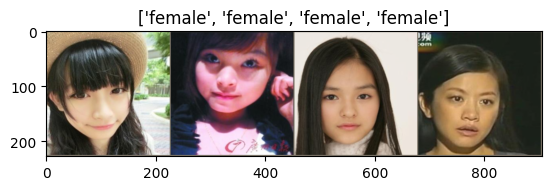

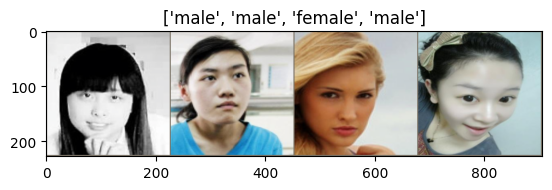

[Test] Loss: 2.0427 Acc: 75.9930% Time: 19.3176s
[Test] Male Accuracy: 96.1965%
[Test] Female Accuracy: 59.8863%


In [11]:

# Validation Phase
# import imshow
import numpy as np
import matplotlib.pyplot as plt
# Define a function to display images
def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

class_names = test_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

male_corrects = 0
male_total = 0
female_corrects = 0
female_total = 0

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        male_mask = labels == class_names.index('male')
        female_mask = labels == class_names.index('female')

        male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
        male_total += torch.sum(male_mask)

        female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
        female_total += torch.sum(female_mask)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                        time.time() - start_time))

    print('[Test] Male Accuracy: {:.4f}%'.format(male_acc))
    print('[Test] Female Accuracy: {:.4f}%'.format(female_acc))

Class names: ['female', 'male']
[Prediction Result Examples]


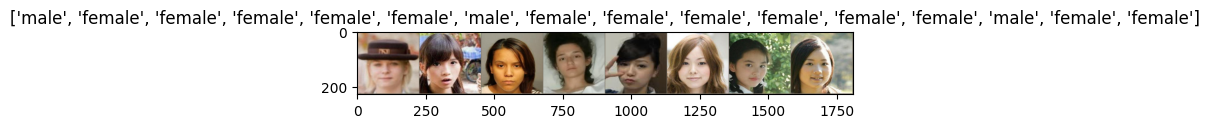

[Validation] Loss: 2.2017 Acc: 75.6149% Time: 19.3840s
[Validation] Male Accuracy: 96.8304%
[Validation] Female Accuracy: 58.7121%


In [12]:
# Validation Phase, using validation dataset
class_names = val_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

male_corrects = 0
male_total = 0
female_corrects = 0
female_total = 0

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        male_mask = labels == class_names.index('male')
        female_mask = labels == class_names.index('female')

        male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
        male_total += torch.sum(male_mask)

        female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
        female_total += torch.sum(female_mask)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            pred_labels = [class_names[x] for x in preds]
            images = torchvision.utils.make_grid(inputs[:8])
            imshow(images.cpu(), title=pred_labels)

    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                        time.time() - start_time))

    print('[Validation] Male Accuracy: {:.4f}%'.format(male_acc))
    print('[Validation] Female Accuracy: {:.4f}%'.format(female_acc))

In [55]:

torch.save(model.state_dict(), 'self_training_final_model-0.9_5_best.pth')
print("Saved PyTorch Model State to self_training_final_model-0.9_5_best.pth")



Model saved to fair-face-pseudo-labelled-AAF-validation-0.3-model.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms



# Define transforms for training and validation data
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_unlabeled = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
